# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом  разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. На основе исторические данные необходимо построить модель для определения стоимости автомобиля. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
! pip install lightgbm


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import re
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import Ridge
warnings.filterwarnings("ignore")

In [3]:
try:
    data = pd.read_csv()
except:
    data = pd.read_csv()

In [4]:
data.head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


In [5]:
data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower()for i in data.columns]

In [6]:
data.describe(include='all')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [8]:
data.duplicated().sum()

4

In [9]:
data = data.drop_duplicates()

In [10]:
# Удалим неинформативные признаки
data = data.drop(['date_crawled', 'date_created','number_of_pictures','last_seen', 'postal_code', 'registration_month'], axis=1)

In [11]:
np.sort(data.registration_year.unique())

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

<AxesSubplot:xlabel='price', ylabel='Count'>

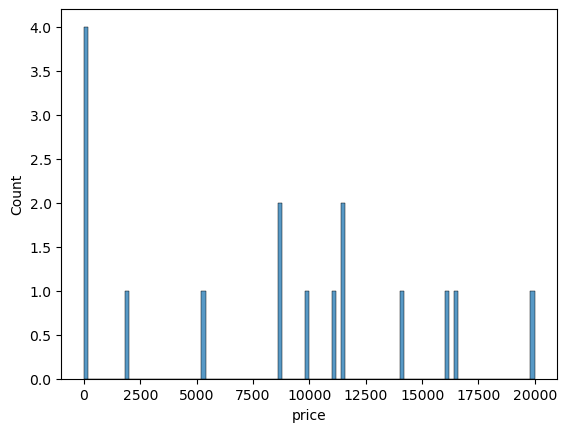

In [12]:
sns.histplot(data.price.loc[(data.registration_year>1910) & (data.registration_year<1930)], bins=100)

In [13]:
data.loc[(data.registration_year>=1910) & (data.registration_year<=1930)].groupby(by=['brand', 'model']).median()

price  registration_year  power  kilometer
brand         model                                                    
audi          100              0.0             1910.0    0.0   150000.0
              a2              99.0             1910.0    0.0     5000.0
              a4               0.0             1910.0    0.0   150000.0
              other         1250.0             1910.0    0.0     5000.0
bmw           3er            200.5             1910.0   85.0    77500.0
              other        11500.0             1929.0   15.0     5000.0
chevrolet     spark            0.0             1930.0   99.0    20000.0
citroen       c3            8750.0             1923.0    9.5     5000.0
              other         2600.0             1919.0    0.0     5000.0
fiat          other            1.0             1910.0    0.0     5000.0
              punto           80.0             1910.0    0.0   150000.0
ford          escort         189.0             1910.0    0.0   150000.0
              ka             300.0             1910.0    0.0     5000.0
              mondeo         180.0             1910.0    0.0   150000.0
              other        13249.5             1927.5   32.0   150000.0
hyundai       other            0.0             1910.0    0.0     5000.0
mercedes_benz gl               0.0             1910.0    0.0     5000.0
              other            1.0             1919.5    5.0    37500.0
mitsubishi    colt             0.0             1910.0    0.0   150000.0
opel          agila          600.0             1910.0    0.0     5000.0
              calibra         30.0             1910.0    0.0   100000.0
              combo            0.0             1910.0    0.0   150000.0
              corsa          250.0             1910.0    0.0   150000.0
              omega            0.0             1910.0  170.0   150000.0
peugeot       other         8000.0             1930.0   23.0   150000.0
renault       espace        1500.0             1910.0  999.0   150000.0
volkswagen    beetle        3400.0             1910.0   90.0    90000.0
              caddy          100.0             1910.0    0.0    77500.0
              golf           261.0             1910.0    0.0   137500.0
              kaefer          50.0             1910.0    0.0     5000.0
              other            0.0             1910.0    0.0     5000.0
              passat        3900.0             1910.0   90.0   150000.0
              polo           150.0             1910.0    0.0     5000.0
              transporter      0.0             1910.0    0.0     5000.0

1910 год ввден по ошибке

<AxesSubplot:xlabel='power', ylabel='Density'>

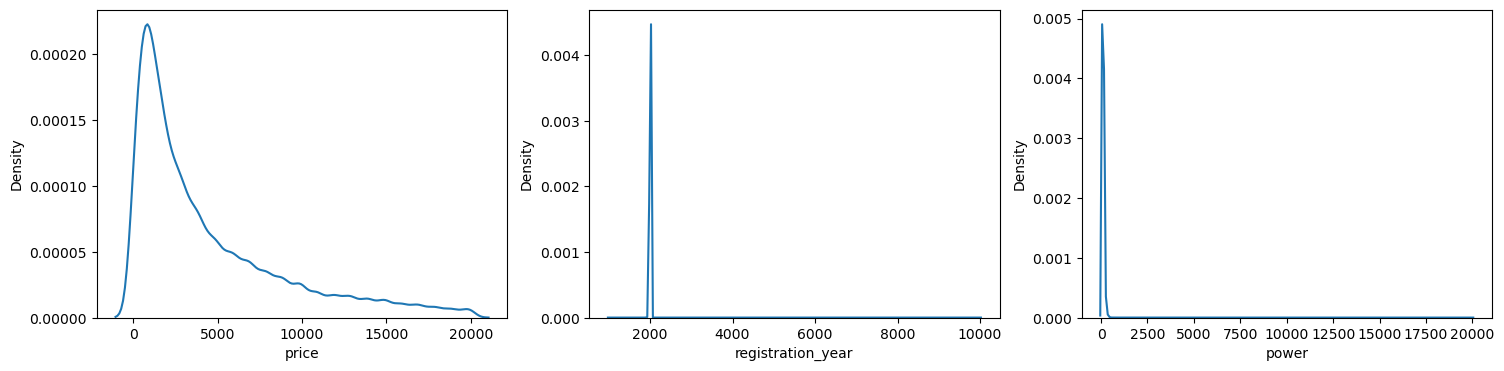

In [14]:
plt.rcParams['figure.figsize'] = (18,4)
fig, ax = plt.subplots(1,3)
sns.kdeplot(data = data.price, ax=ax[0])
sns.kdeplot(data = data.registration_year, ax=ax[1])
sns.kdeplot(data = data.power, ax=ax[2])

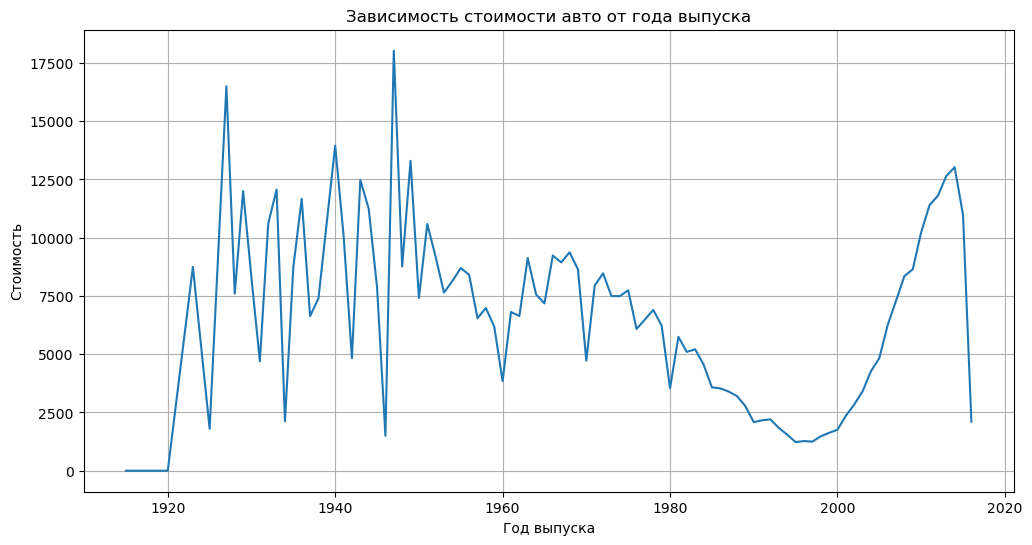

In [15]:
#Строим график зависимости цены авто от года
plt.figure(figsize=(12,6))
plt.plot(data[(data.registration_year>1910) & (data.registration_year<=2016)].groupby('registration_year')['price'].mean())
plt.title("Зависимость стоимости авто от года выпуска")
plt.xlabel('Год выпуска')
plt.ylabel('Стоимость')
plt.grid(True)
plt.show();

в 2016 цена падает, надо разобраться

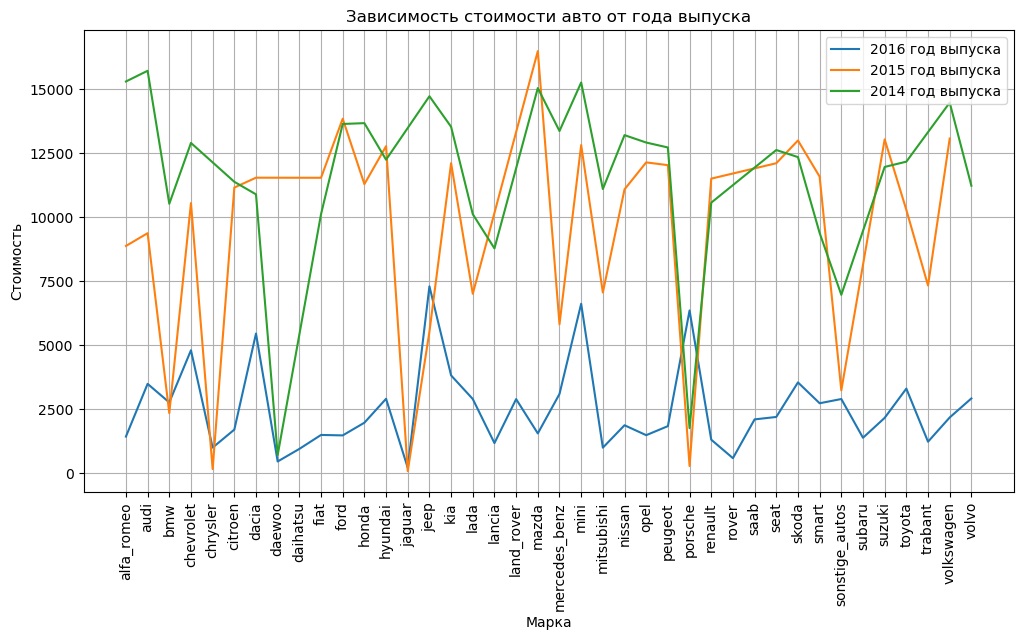

In [16]:
#Строим график зависимости цены авто от марки
plt.figure(figsize=(12,6))
plt.plot(data[data.registration_year==2016].groupby('brand')['price'].mean(), label='2016 год выпуска')
plt.plot(data[data.registration_year==2015].groupby('brand')['price'].mean(), label='2015 год выпуска')
plt.plot(data[data.registration_year==2014].groupby('brand')['price'].mean(), label='2014 год выпуска')
plt.legend()
plt.title("Зависимость стоимости авто от года выпуска")
plt.xlabel('Марка')
plt.ylabel('Стоимость')
plt.grid(True)
plt.xticks(rotation=90);

Что-то явно не то с 2016 годом, информация не достоверна, новые авто не могут стоить дешевле, чем 2-3 летние

In [17]:
# Введем дополнительные категории в зависимости от года и цены авто: ретро, супер-ретро, старая, новая

data.loc[(data['registration_year']<=1975) & (data['price']<=7500), 'car_category'] = 'retro'
data.loc[(data['registration_year']<=1975) & (data['price']>7500), 'car_category'] = 'super_retro'
data.loc[(data['registration_year']>1975) & (data['registration_year']<=2007), 'car_category'] = 'old'
data.loc[(data['registration_year']>2007), 'car_category'] = 'new'

In [18]:
# тут я собрал предобработку данных, основываясь на анализе полного датасета. Для того, что бы отдельно обработать train, test и valid выборки. 
def preprocessing_data(features, target):
 
    # Заменим пропуски в "gearbox" на manual
    features.gearbox = features.gearbox.fillna('manual')
    
    # Заменим пропуски в "repaired" на no
    features.repaired = features.repaired.fillna('no')
    
    # Заменим пропуски в "fuel_type". По цене unknown ближе всего к категории other, объединим их
    features.fuel_type = features.fuel_type.fillna('other')
                
    # Заменим пропуски в model по моде 3 похожих известных записаей
    features.model = features.model.fillna('unknown')
    features = features.sort_values(by=['brand', 'vehicle_type', 'registration_year', 'model', 'power']).reset_index()
    index_unknown = features.loc[(features.model == 'unknown'), 'model'].index
    
    for index in index_unknown:
        neighbors = []
        i = 1
        while len(neighbors) < 4:
            if index - i >=0 and features.loc[index - i, 'model'] != 'unknown':
                neighbors.append(features.loc[index - i, 'model'])
            elif index + i <= len(features) and features.loc[index + i, 'model'] != 'unknown':
                neighbors.append(features.loc[index + i, 'model'])
            i += 1
        features.loc[index, 'model'] = pd.Series(neighbors).mode()[0] 
        
    features = features.set_index('index')
    features.index.names = [None]    
        
    # Заменим пропуски в vehicle_type по моде модели
    
    for model in features.model.unique():
        if features.loc[features['model'] == model, 'vehicle_type'].mode().shape[0] != 0:
            features.loc[(features['model'] == model) & (features['vehicle_type'].isna()), 'vehicle_type'] =\
                features.loc[features['model'] == model, 'vehicle_type'].mode()[0]
    
    # Удалим строки где пропущены все ключевые значения
    features = features.drop(
        features.loc[
            (features['vehicle_type'].isna()) & 
            (features['gearbox'].isna()) & 
            (features['model'].isna()) & 
            (features['fuel_type'].isna()) & 
            (features['repaired'].isna())].index)
    
    

    # Удалим данные с датой выпуска ранее 1927 и старше 2016, как ошибочные
    # Так же удаляем авто 2016 года, т.к. выявлена аномалия
    features = features.drop(features.loc[(features['registration_year']<1927) | (features['registration_year']>=2016)].index)
            
    # Удалим данные с мощностью более 600, как ошибочные    
    features = features.drop(features.loc[features['power']>600].index)
    
    # Удалим записи с мощностью двигателя = 0, т.к. скорее всего это авто со сломанным двигателем. Такие машины должны относится к другой категории, и нашей модели и бизнесу они не особо нужны
    features = features.drop(features.loc[features['power']==0].index)
        
    # Удалим данные с ценой менее 50$ так как у авто всегда есть небольшая остаточная стоимость, 
    # и отдав авто на junkyard или разборку, можно тут же получить деньги, либо подарить официальной non profit организации и списать налоги
    features = features.drop(features.loc[target<50].index)
    
    #количество фичей должно равняться каличеству таргетов
    target = target[features.index]
    
    
    return features, target


Всю обработку выборок делаем в функции, удаляем авто с 2016 года, и старше, включительно. 

In [19]:
# Разделим данные на выборки
features_train, features_valid, target_train, target_valid = train_test_split(
    data.drop('price', axis=1), data.price, test_size=0.3, random_state=12345)

features_test, features_valid, target_test, target_valid = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)

In [20]:
features_train.shape, target_train.shape, features_test.shape, target_test.shape, features_valid.shape, target_valid.shape

((248055, 10), (248055,), (53155, 10), (53155,), (53155, 10), (53155,))

In [21]:
data.loc[data.power==0]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,car_category
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,old
15,450,small,1910,NaN,0,ka,5000,petrol,ford,NaN,retro
32,245,sedan,1994,NaN,0,golf,150000,petrol,volkswagen,no,old
37,1500,NaN,2016,NaN,0,kangoo,150000,gasoline,renault,no,new
40,0,NaN,1990,NaN,0,corsa,150000,petrol,opel,NaN,old
...,...,...,...,...,...,...,...,...,...,...,...
354338,180,NaN,1995,NaN,0,NaN,125000,petrol,opel,NaN,old
354346,2600,NaN,2005,auto,0,c_klasse,150000,NaN,mercedes_benz,NaN,old
354363,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no,old
354364,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes,old


In [22]:
data['power_0'] = 'no'
data.loc[data['power'] == 0, 'power_0'] = 'yes'

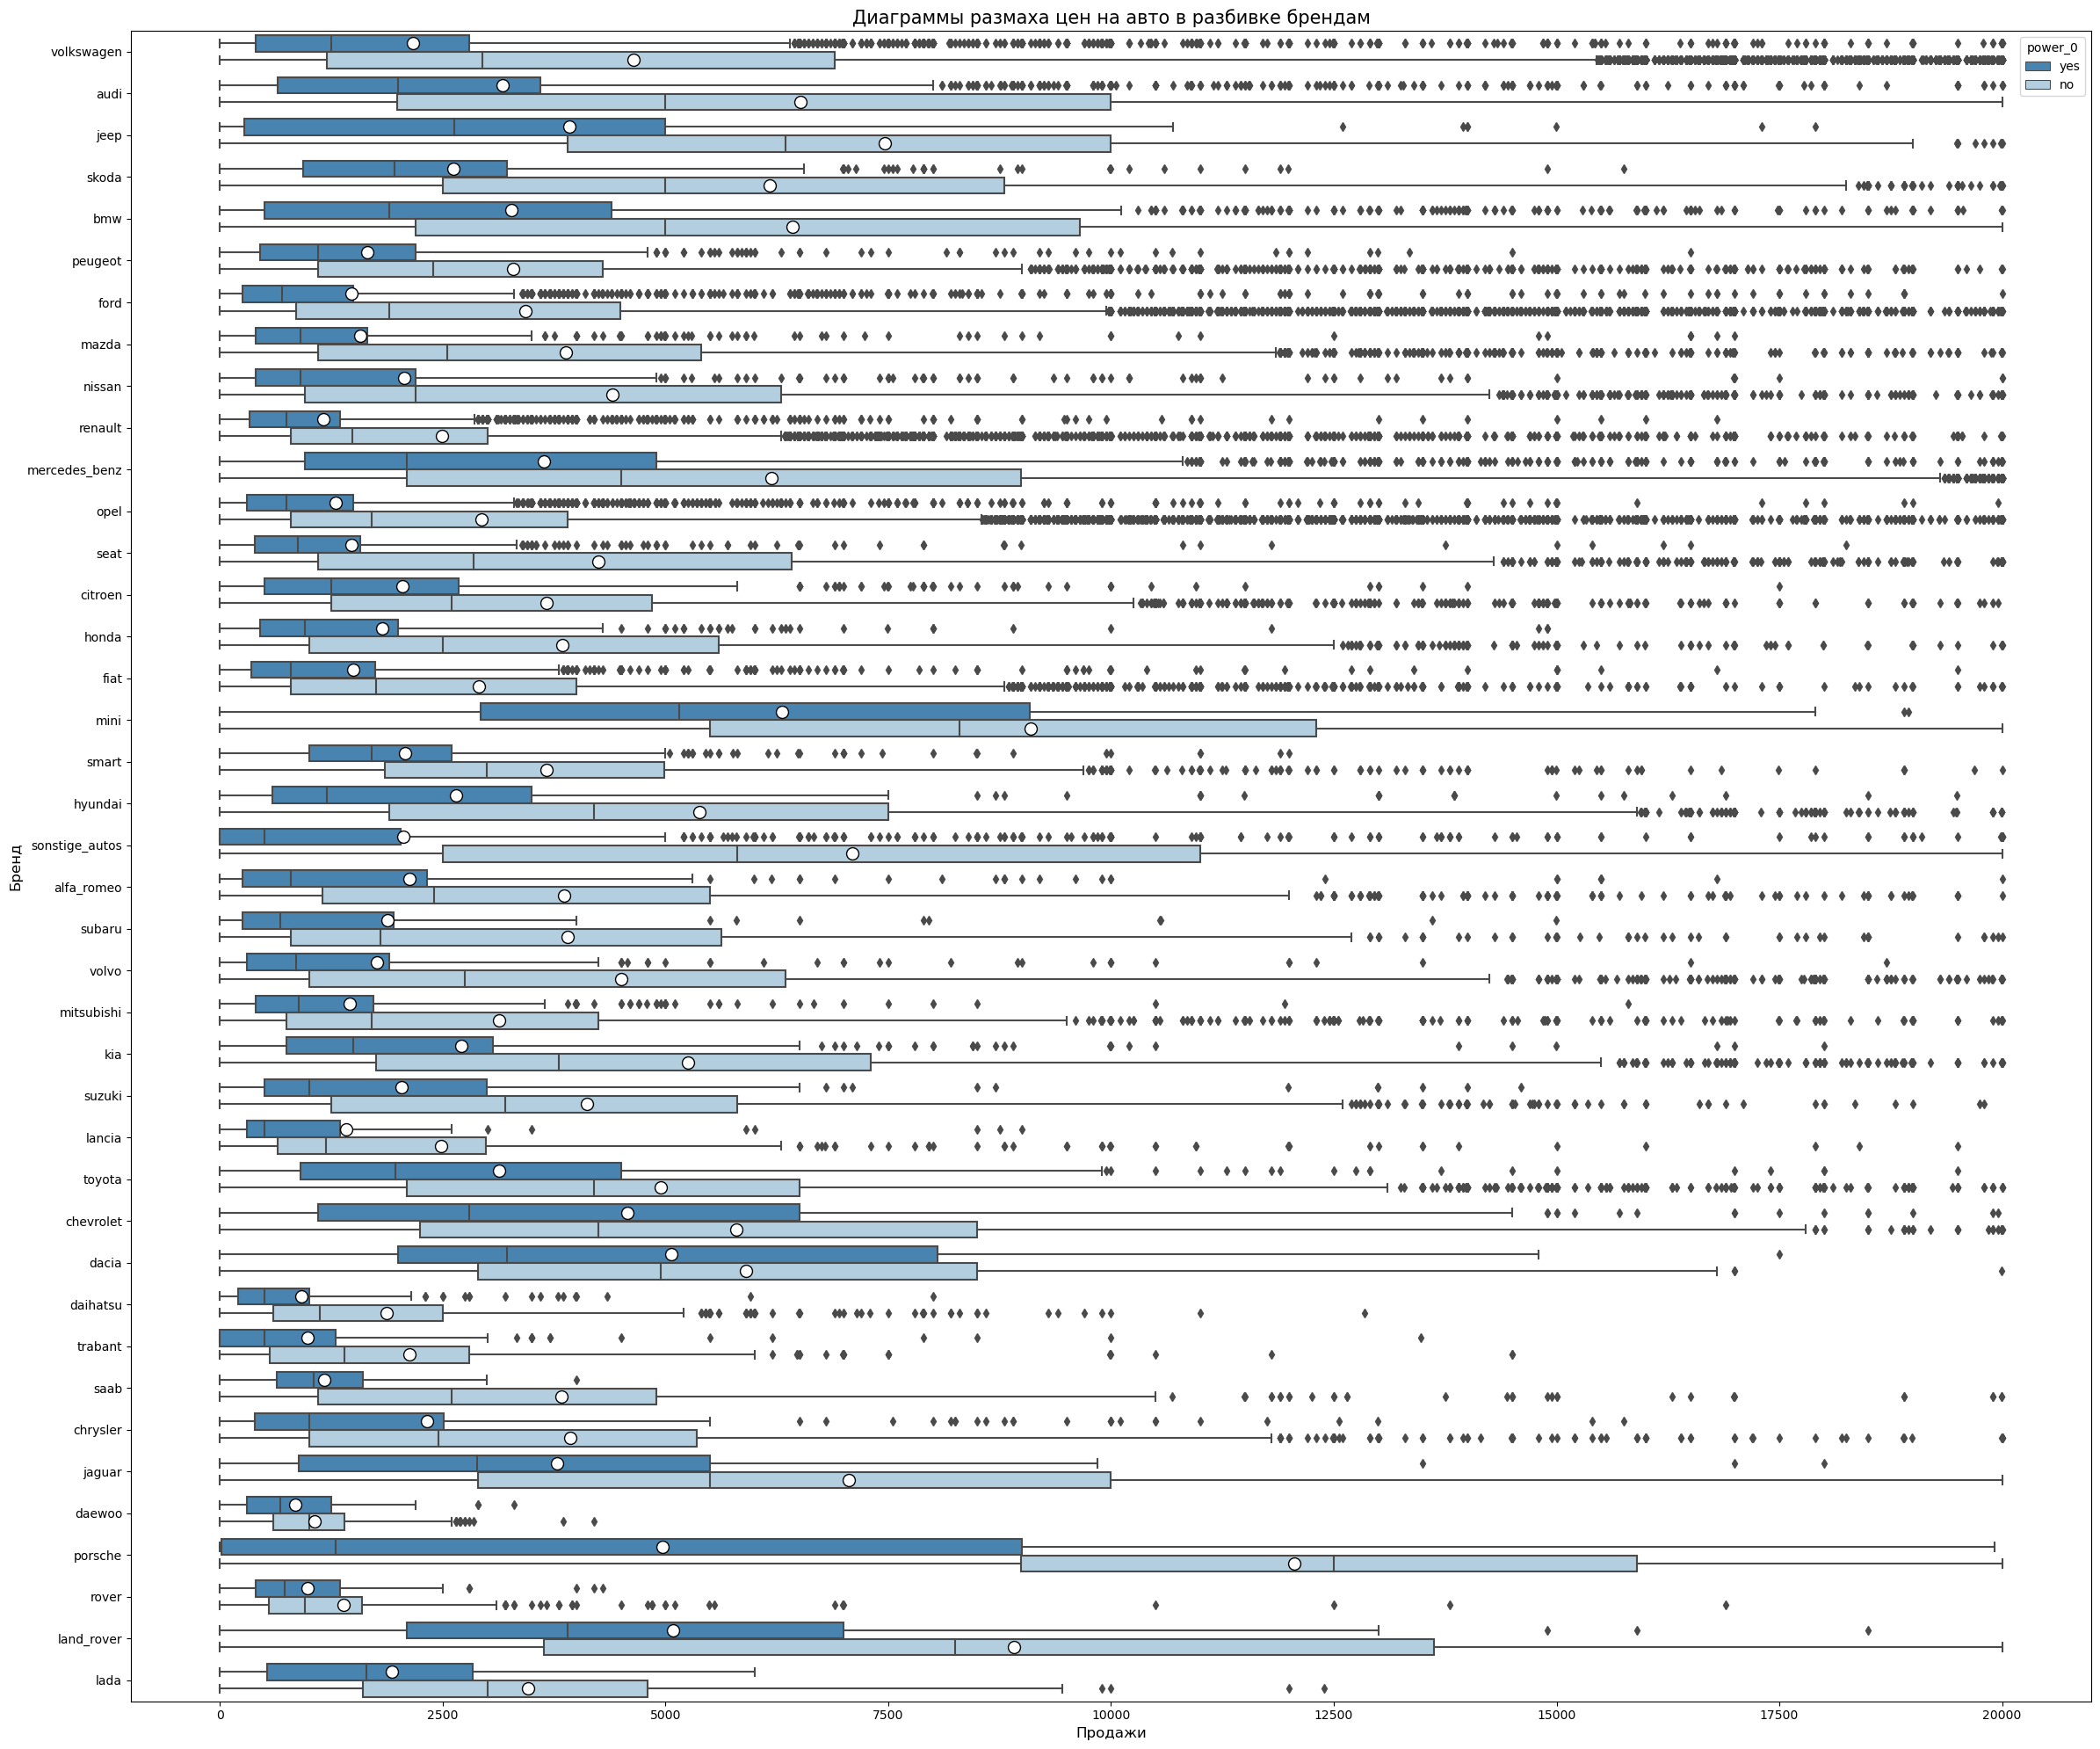

In [23]:
plt.figure(figsize=(24,20))
sns.boxplot(data=data, x='price', y='brand', showmeans=True, palette='Blues_r', hue='power_0',
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.title('Диаграммы размаха цен на авто в разбивке брендам', fontsize=15)
plt.xlabel('Продажи', fontsize=12)
plt.ylabel('Бренд',fontsize=12)
plt.tight_layout()

похоже, что значение 0 соответствует сломанному двигателю. Цена на такие авто ниже. 

In [24]:
data.brand.unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

In [25]:
data.gearbox.unique()

array(['manual', 'auto', nan], dtype=object)

In [26]:
data.gearbox.value_counts()

manual    268249
auto       66283
Name: gearbox, dtype: int64

In [27]:
data.isna().sum()

price                    0
vehicle_type         37490
registration_year        0
gearbox              19833
power                    0
model                19705
kilometer                0
fuel_type            32895
brand                    0
repaired             71154
car_category             0
power_0                  0
dtype: int64

In [28]:
data.fuel_type = data.fuel_type.fillna('unknown')

In [29]:
data.pivot_table(index='fuel_type', aggfunc='median')

,kilometer,power,price,registration_year
fuel_type,,,,
cng,150000,97,3650.0,2006
electric,30000,19,5799.5,2011
gasoline,150000,131,5200.0,2006
hybrid,80000,99,9990.0,2010
lpg,150000,140,2983.5,2002
other,80000,1,974.5,1998
petrol,150000,99,2000.0,2001
unknown,150000,70,1100.0,2002


In [30]:
# Petrol и gasoline это бензин, значение обоих терминов одинаково, в зависимости от региона называют по разному.
# LPG (Liquified Petroleum Gas) – сжиженный газ (пропан-бутан)
# CNG (Compressed Natural Gas) – сжатый природный газ (метан)
# что такое Other? на дровах, лошадиной тяге, возможно со сломанным двигателем, так как средняя цена на такие машины очень низкая
# hybrid electric понятно
# Почему нет дизеля?

data.fuel_type.value_counts()

petrol      216349
gasoline     98719
unknown      32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64


<div class="alert alert-block alert-success">
<b>Успех:</b>  Хорошие вопросы ты задаешь... мне тоже интересно куда делся дизель
</div>

In [31]:
data.pivot_table(index='fuel_type', aggfunc='median')

,kilometer,power,price,registration_year
fuel_type,,,,
cng,150000,97,3650.0,2006
electric,30000,19,5799.5,2011
gasoline,150000,131,5200.0,2006
hybrid,80000,99,9990.0,2010
lpg,150000,140,2983.5,2002
other,80000,1,974.5,1998
petrol,150000,99,2000.0,2001
unknown,150000,70,1100.0,2002


In [32]:
data.model = data.model.fillna('unknown')

In [33]:
data.isna().sum()

price                    0
vehicle_type         37490
registration_year        0
gearbox              19833
power                    0
model                    0
kilometer                0
fuel_type                0
brand                    0
repaired             71154
car_category             0
power_0                  0
dtype: int64

In [34]:
data.sort_values(by=['brand', 'vehicle_type', 'registration_year', 'model', 'power'])

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,car_category,power_0
215074,10000,convertible,1965,manual,0,other,10000,petrol,alfa_romeo,yes,super_retro,yes
103962,11900,convertible,1972,manual,131,spider,125000,petrol,alfa_romeo,no,super_retro,no
309438,5999,convertible,1972,manual,131,spider,125000,petrol,alfa_romeo,no,retro,no
294151,15000,convertible,1974,manual,87,spider,80000,petrol,alfa_romeo,no,super_retro,no
131162,15000,convertible,1975,NaN,0,spider,50000,unknown,alfa_romeo,no,super_retro,yes
...,...,...,...,...,...,...,...,...,...,...,...,...
287651,5500,NaN,2018,manual,0,v50,150000,gasoline,volvo,no,new,yes
198445,3499,NaN,2018,manual,136,v50,150000,unknown,volvo,no,new,no
300803,4499,NaN,2018,manual,136,v50,150000,gasoline,volvo,no,new,no
199380,2100,NaN,2018,manual,140,v70,150000,unknown,volvo,yes,new,no


In [35]:
data.vehicle_type.value_counts()

sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: vehicle_type, dtype: int64

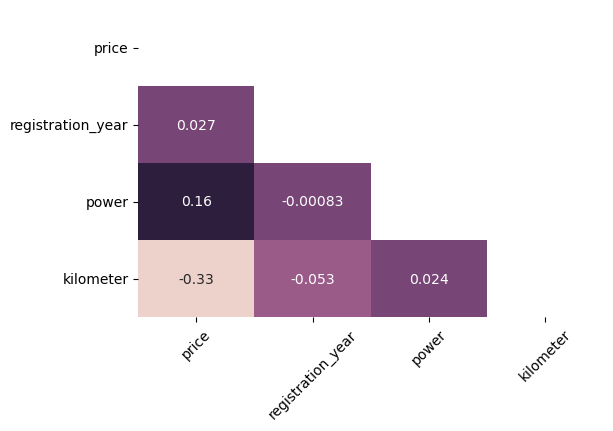

In [36]:
plt.rcParams['figure.figsize'] = (6,4)

# верхний треугольник корреляционной матриццы
matrix = np.triu(data.corr())

sns.heatmap(data.corr(), annot = True, cmap = sns.cubehelix_palette(8), cbar=False, mask=matrix)
plt.xticks(rotation=45);

In [37]:
features_train, target_train = preprocessing_data(features_train, target_train)
features_test, target_test = preprocessing_data(features_test, target_test)
features_valid, target_valid = preprocessing_data(features_valid, target_valid)
features_train.shape, target_train.shape, features_test.shape, target_test.shape, features_valid.shape, target_valid.shape

((202642, 10), (202642,), (43452, 10), (43452,), (43369, 10), (43369,))

In [38]:
# from phik import report
# rep = report.correlation_report(features_train, significance_threshold=3, correlation_threshold=0.5)

In [39]:
features_train.isna().sum(), features_test.isna().sum(), features_valid.isna().sum() 

(vehicle_type         0
 registration_year    0
 gearbox              0
 power                0
 model                0
 kilometer            0
 fuel_type            0
 brand                0
 repaired             0
 car_category         0
 dtype: int64,
 vehicle_type         0
 registration_year    0
 gearbox              0
 power                0
 model                0
 kilometer            0
 fuel_type            0
 brand                0
 repaired             0
 car_category         0
 dtype: int64,
 vehicle_type         0
 registration_year    0
 gearbox              0
 power                0
 model                0
 kilometer            0
 fuel_type            0
 brand                0
 repaired             0
 car_category         0
 dtype: int64)

## Обучение моделей

In [40]:
#категориальные признаки для OHE
ohe_features = features_train.select_dtypes(include='object').columns.to_list()
ohe_features

['vehicle_type',
 'gearbox',
 'model',
 'fuel_type',
 'brand',
 'repaired',
 'car_category']

In [41]:
#численные признаки
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
num_features

['registration_year', 'power', 'kilometer']

In [42]:
#признаки для lgbm для внутреннего кодирования

features_train_lgbm = features_train.copy()
features_test_lgbm = features_test.copy()
features_valid_lgbm = features_valid.copy()

for feature in ohe_features:
    features_train_lgbm[feature] = pd.Series(data[feature], dtype="category")
    features_test_lgbm[feature] = pd.Series(data[feature], dtype="category")
    features_valid_lgbm[feature] = pd.Series(data[feature], dtype="category")

In [43]:
# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку
# задаём handle_unknown='ignore':
# игнорируется ранее невстречающиеся значения признака (при transform)
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(features_train[ohe_features])

# добавляем закодированные признаки в X_train_ohe
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
features_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train[ohe_features])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train = features_train.drop(ohe_features, axis=1)

# создаём скелер
scaler = MinMaxScaler()

# обучаем его на численных признаках тренировочной выборки, трансформируем её же
features_train[num_features] = scaler.fit_transform(features_train[num_features])

# смотрим на результат
features_train.head()

,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,...,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_yes,car_category_old,car_category_retro,car_category_super_retro
103962,0.511364,0.217028,0.827586,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
309438,0.511364,0.217028,0.827586,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
294151,0.534091,0.143573,0.517241,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
249759,0.568182,0.143573,0.655172,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
159870,0.568182,0.212020,0.827586,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [44]:
# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем тестовую
features_valid[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_valid[ohe_features])

features_valid = features_valid.drop(ohe_features, axis=1)

# скелером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, масштабируем тестовую
features_valid[num_features] = scaler.transform(
    features_valid[num_features]
)

# смотрим на результат
features_valid.head()

,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,...,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_yes,car_category_old,car_category_retro,car_category_super_retro
226035,0.590909,0.223706,0.517241,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
232522,0.613636,0.208681,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
149451,0.636364,0.171953,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
343893,0.636364,0.208681,0.827586,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
320863,0.681818,0.191987,0.655172,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [45]:
# получилось одинаковое количество признаков
features_train.shape, target_train.shape, features_test.shape, target_test.shape, features_valid.shape, target_valid.shape

((202642, 308), (202642,), (43452, 10), (43452,), (43369, 308), (43369,))

## Анализ моделей

In [46]:
#define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1234)

In [47]:
lgbm = lgb.LGBMRegressor(objective ='regression',
                         metric = 'mae',
                         random_state = 42)

#Функция расчета RMSE
def rmse (target, predictions):
    result = mean_squared_error(target,predictions)**0.5
    return result

rmse_scorer = make_scorer(rmse, greater_is_better=False)

#USING GRID SEARCH
params_lgbm = {
    # The maximum number of leaves per tree; higher num_leaves means less conservative/control, potentially overfitting (default is 31)
    'num_leaves':[26, 13],
    # Lower means longer to train but more accurate # Should not interfere with overfitting (default is 0.1)
    'learning_rate':[0.07552619413921881,],
    # The more trees the less likely the algorithm is to overfit. So try increasing the number of estimators. (default is 100)
    'n_estimators':[1000, 500],
    # The ratio of features used (i.e. columns used); colsample_bytree. Lower ratios avoid over-fitting. (default is 1.0)
    'colsample_bytree': [0.5,],
    # The ratio of the training instances used (i.e. rows used); subsample. Lower ratios avoid over-fitting. (default is 1.0)
    'subsample': [0.6633806094241483, 1],
    #Penalize too small weights by L1 and high weights (== outliers) by L2 to prevent overfitting. 
    'reg_alpha': [0.05,], # L1 regularization (default is 0.0)
    'reg_lambda': [0], # L2 regularization (default is 0.0)
    # This controls the complexity of branching; Decreasing this value prevents overfitting. (default is -1)
    #'max_depth': [17,-1],
               } 

grid_search_lgbm = GridSearchCV(estimator=lgbm, 
                                param_grid=params_lgbm,
                                verbose = 1, 
                                cv = cv,
                                scoring= rmse_scorer,
                                n_jobs=-1).fit(features_train_lgbm, target_train)

lgbm_best = grid_search_lgbm.best_estimator_
print('lgbm Regressor Best Parmas', grid_search_lgbm.best_params_)
print('lgbm Regressor RMSE =', np.abs(grid_search_lgbm.best_score_))

Fitting 30 folds for each of 8 candidates, totalling 240 fits
lgbm Regressor Best Parmas {'colsample_bytree': 0.5, 'learning_rate': 0.07552619413921881, 'n_estimators': 1000, 'num_leaves': 26, 'reg_alpha': 0.05, 'reg_lambda': 0, 'subsample': 0.6633806094241483}
lgbm Regressor RMSE = 1506.3902252490843


In [48]:
grid_search_lgbm.cv_results_['mean_fit_time'], grid_search_lgbm.cv_results_['rank_test_score']

(array([13.32349238, 13.31089346, 11.9963656 , 11.50862065,  7.10494634,
         7.04422523,  6.31649419,  5.94189809]),
 array([1, 1, 5, 5, 3, 3, 7, 7]))

In [49]:
%%time
pred = grid_search_lgbm.predict(features_valid_lgbm)
rmse(target_valid, pred)

Wall time: 414 ms


1489.43226924246

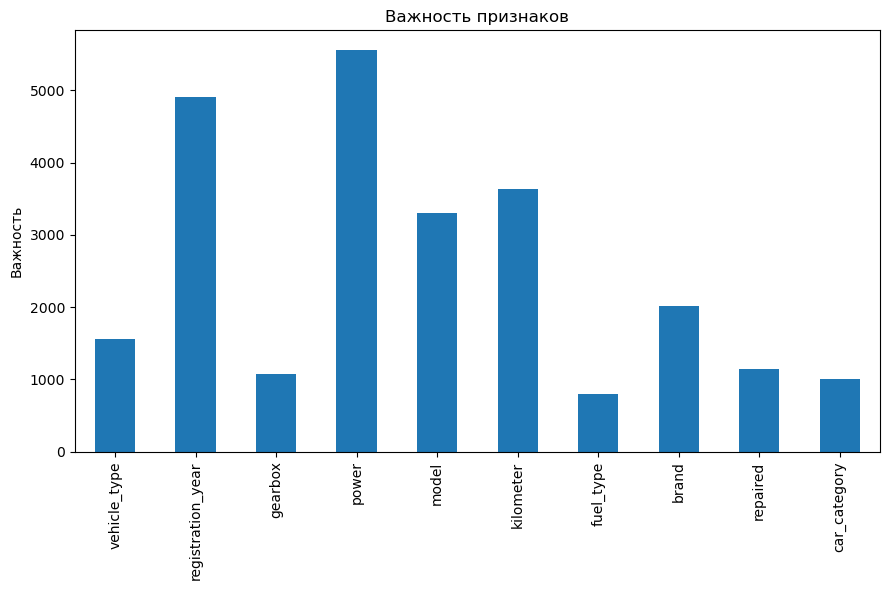

In [50]:
#Важность признаков

lgbm_best.feature_importances_

lgbm_best_imp = pd.Series(lgbm_best.feature_importances_,
                         features_valid_lgbm.columns)

fig, ax = plt.subplots(figsize=(9,6))
lgbm_best_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

Отлично видно, что мощность самый важный признак для модели, при выявлении стоимости.

In [51]:
model_ridge = Ridge()

parameters_ridge = {
    'solver':['svd', 'cholesky'],
    'alpha': [1e-1, 100],
    'normalize':[True, False]
}

# Условия поиска
search_ridge = GridSearchCV(model_ridge, parameters_ridge, scoring=rmse_scorer, n_jobs=-1, cv=cv)
# Подбор гиперпараметров
search_ridge.fit(features_train, target_train)

print('Лучшая оцценка sMAPE: %s' % search_ridge.best_score_)
print('Лучшие гиперпараметры: %s' % search_ridge.best_params_)

Лучшая оцценка sMAPE: -2266.9922984782243
Лучшие гиперпараметры: {'alpha': 0.1, 'normalize': False, 'solver': 'cholesky'}


In [52]:
search_ridge.cv_results_['mean_fit_time'], search_ridge.cv_results_['rank_test_score']

(array([44.02102447,  8.81713289, 41.54387916,  6.59889485, 43.3841457 ,
         8.69567189, 41.76880292,  6.72706873]),
 array([4, 3, 2, 1, 7, 7, 6, 5]))

In [53]:
%%time
pred_ridge = search_ridge.predict(features_valid)
rmse(target_valid, pred_ridge)

Wall time: 241 ms


2232.3293143732376

In [54]:
predict_dummy = np.ones(target_valid.shape) * target_valid.mean()


In [55]:
print('Метрика RMSE для дамми модели:', rmse(target_valid, predict_dummy))

Метрика RMSE для дамми модели: 4619.4102051630425


In [56]:
%%time
# тестирование выбранной модели
best_predict_lgbm = lgbm_best.predict(features_test_lgbm)
print('Метрика RMSE на тестовой выборке LightGBM:', rmse(target_test, best_predict_lgbm))

Метрика RMSE на тестовой выборке LightGBM: 1508.1428895427127
Wall time: 462 ms


Наша модель показывает гораздо лучшую метрику, по сравнению с дамми моделью

### Вывод:

Загрузив датасет, сделали предобработку, некоторые выявленные аномалии и неинформативные признаки были исключены из датасета. Пропуски заполнены.   

Подготовленны выборки для обучения, валидации и тестирования модели. Выборки разделены на 2 группы - одна для LightGBM, вторая для линейной модели Ridge.   

Проведена подборка гиперпараметров кросс-валлидацией методом GridSearchCV, на обучении и валидации модели показали себя следующим образом:  

Для LightGBM время обучения составило 12.84143617 секунд, при RMSE = 1506.3902252490843. Время пердсказания на валидационной выборке составило 427 ms, метрика RMSE = 1489.43226924246 

Для модели Ridge время обучения составило 6.91654403 секунд, при RMSE = 2266.9922984782243. Время пердсказания на валидационной выборке составило 208 ms, метрика RMSE = 2232.3293143732376   

Получается, что LightGBM дает лучшую метрику, но Ridge обучается, и предсказывает в 2 раза быстрее.   

Думаю, что резоннее выбрать LightGBM, так как ее метрика сильно превосходит Ridge.  

Для LightGBM проведено тестирование, которое показало, что:   

Время пердсказания на тестовой выборке составило 342 ms, метрика RMSE = 1508.1428895427127 


